In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wsdm-kkbox/song_extra_info.csv
/kaggle/input/wsdm-kkbox/members.csv
/kaggle/input/wsdm-kkbox/test.csv
/kaggle/input/wsdm-kkbox/songs.csv
/kaggle/input/wsdm-kkbox/train.csv


In [10]:
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve
from tqdm import tqdm
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as msno
import gc
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier

In [11]:
from subprocess import check_output

train = pd.read_csv('/kaggle/input/wsdm-kkbox/train.csv')
test = pd.read_csv('/kaggle/input/wsdm-kkbox/test.csv')
songs = pd.read_csv('/kaggle/input/wsdm-kkbox/songs.csv')
members = pd.read_csv('/kaggle/input/wsdm-kkbox/members.csv')


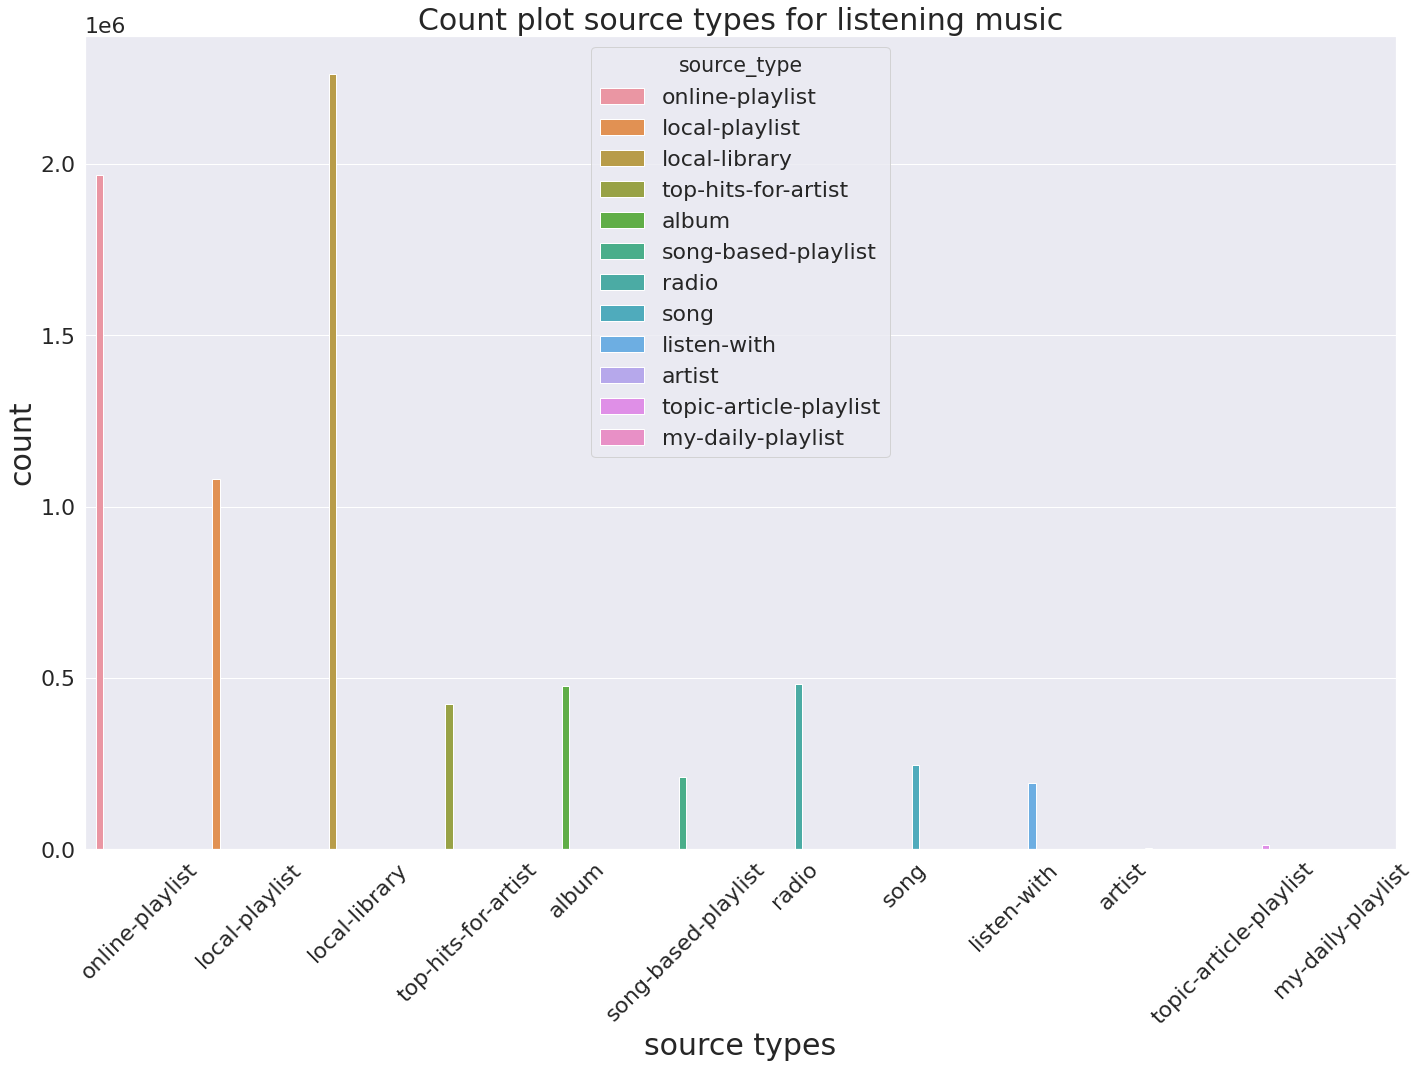

In [12]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_type',hue='source_type',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot source types for listening music',fontsize=30)
plt.tight_layout()

In [13]:
1+1

2

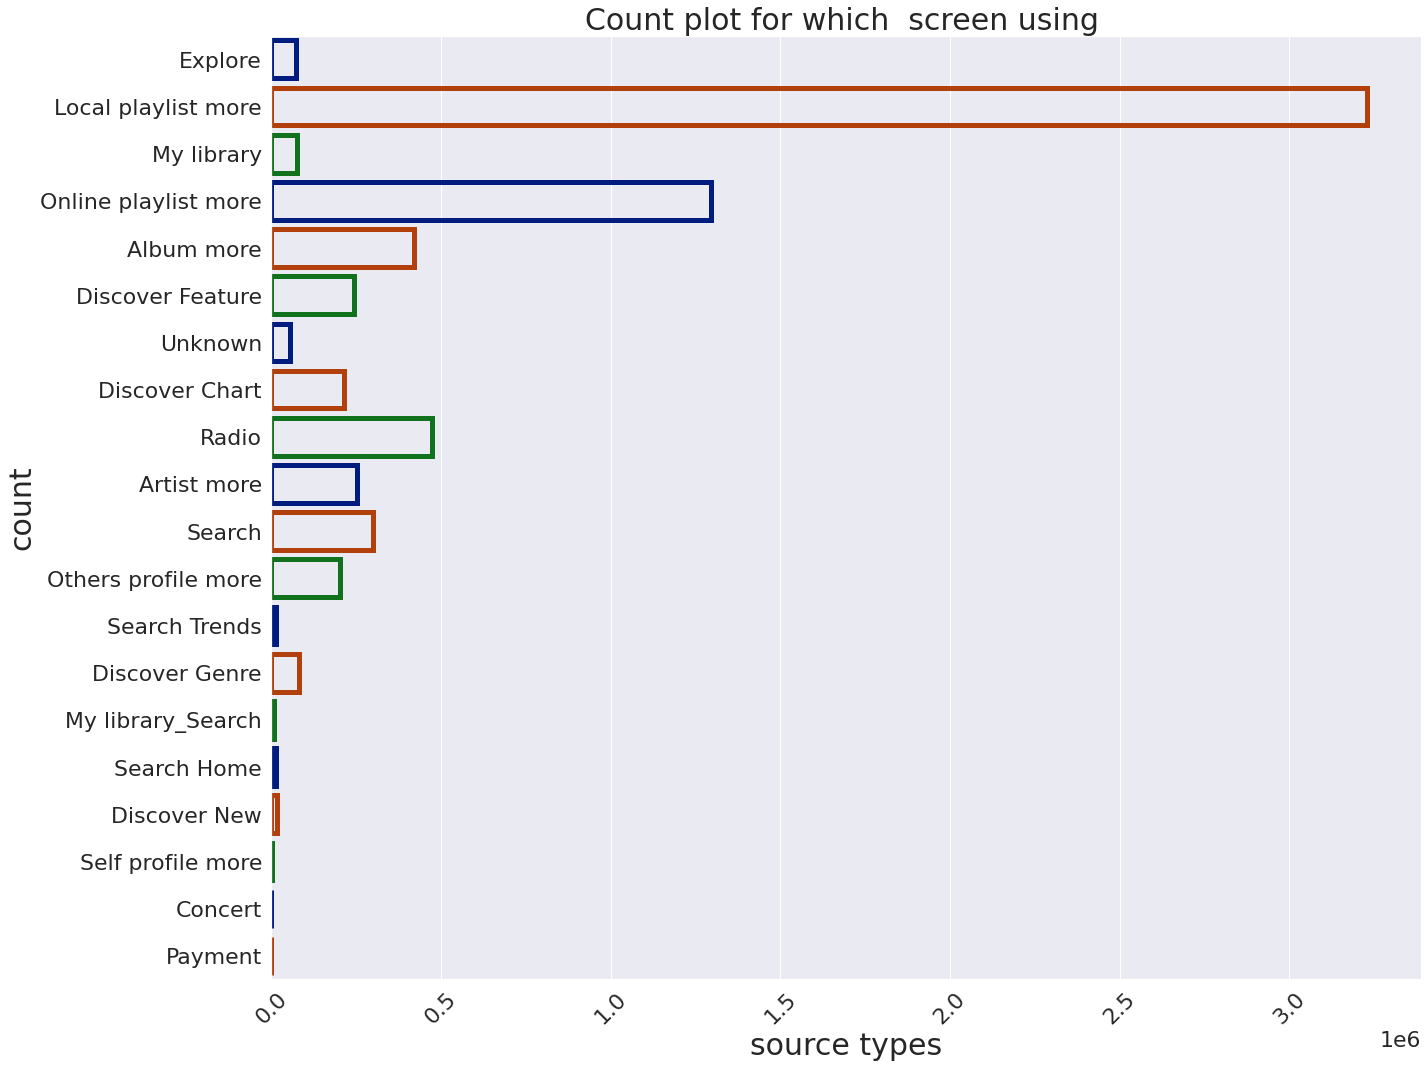

In [14]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(y='source_screen_name',data=train,facecolor=(0,0,0,0),linewidth=5,edgecolor=sns.color_palette('dark',3))
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for which  screen using ',fontsize=30)
plt.tight_layout()

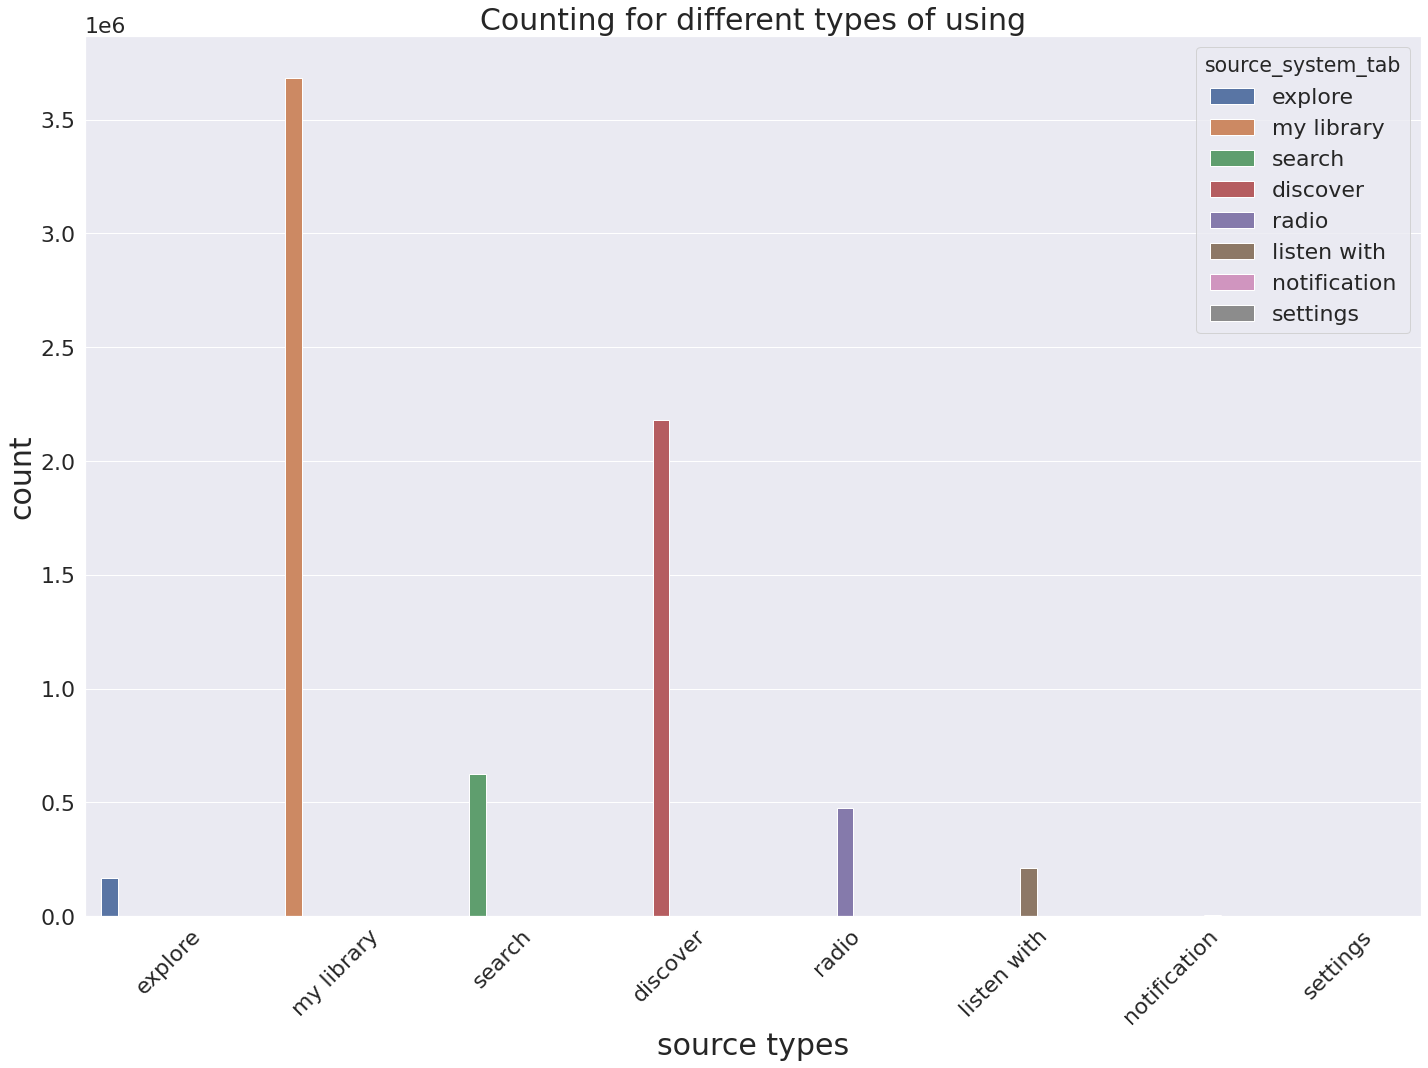

In [17]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_system_tab',hue='source_system_tab',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Counting for different types of using',fontsize=30)
plt.tight_layout()

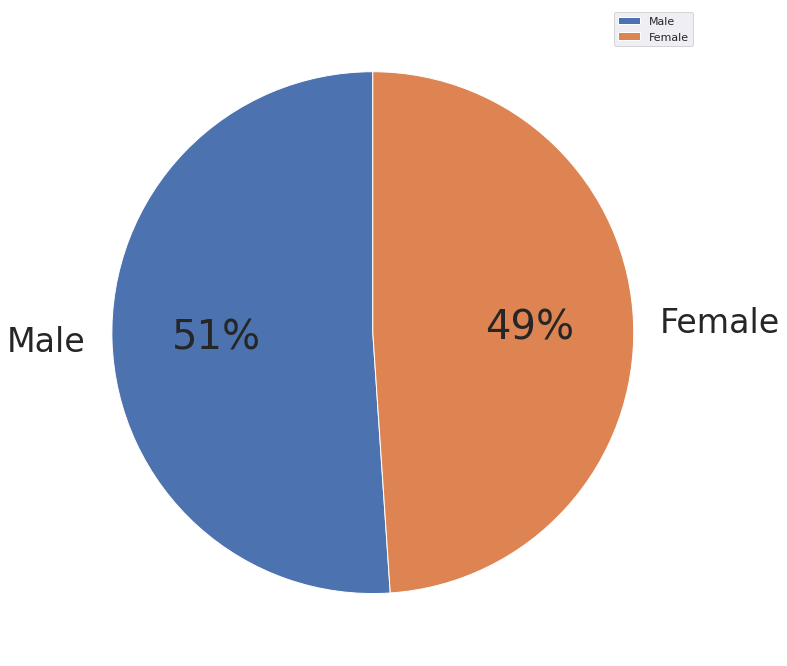

In [16]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 40.0
labels = ['Male','Female']
plt.figure(figsize = (12, 12))
sizes = pd.value_counts(members.gender)
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, autopct='%.0f%%',
                                    shadow=False, radius=1,startangle=90)
for t in texts:
    t.set_size('smaller')
plt.legend()
plt.show()

my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: source_system_tab, dtype: int64


<Figure size 1584x1584 with 0 Axes>

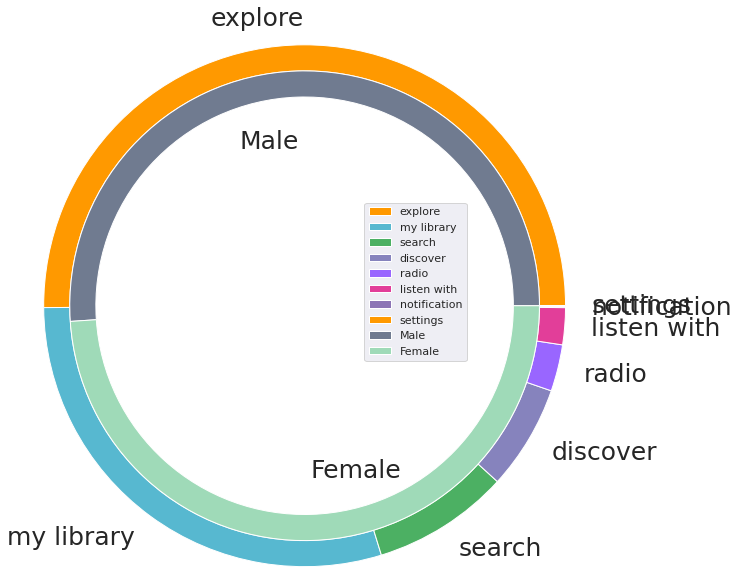

In [23]:
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (22, 22)) 
# Make data: I have 3 groups and 7 subgroups
group_names=['explore','my library','search','discover','radio','listen with','notification','settings']
group_size=pd.value_counts(train.source_system_tab)
print(group_size)
subgroup_names=['Male','Female']
subgroup_size=pd.value_counts(members.gender)
 
# Create colors
a, b, c,d,e,f,g,h=[plt.cm.autumn, plt.cm.GnBu, plt.cm.YlGn,plt.cm.Purples,plt.cm.cool,plt.cm.RdPu,plt.cm.BuPu,plt.cm.bone]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, texts= ax.pie(group_size, radius=3.0,labels=group_names, colors=[a(0.6), b(0.6), c(0.6),d(0.6), e(0.6), f(0.6),g(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
#Second Ring (Inside)
mypie2, texts1 = ax.pie(subgroup_size, radius=3.0-0.3, labels=subgroup_names, labeldistance=0.7, colors=[h(0.5), b(0.4)])
plt.setp( mypie2, width=0.3, edgecolor='white')
plt.margins(0,0)
for t in texts:
    t.set_size(25.0)
for t in texts1:
    t.set_size(25.0)    
plt.legend() 
# show it
plt.show()

In [24]:
members.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,34403.000000,34403.000000,34403.000000,3.440300e+04,3.440300e+04
mean,5.371276,12.280935,5.953376,2.013994e+07,2.016901e+07
std,6.243929,18.170251,2.287534,2.954015e+04,7.320925e+03
min,1.000000,-43.000000,3.000000,2.004033e+07,1.970010e+07
25%,1.000000,0.000000,4.000000,2.012103e+07,2.017020e+07
50%,1.000000,0.000000,7.000000,2.015090e+07,2.017091e+07
75%,10.000000,25.000000,9.000000,2.016110e+07,2.017093e+07
max,22.000000,1051.000000,16.000000,2.017023e+07,2.020102e+07


In [25]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


Text(0.5, 0, 'registration time ')

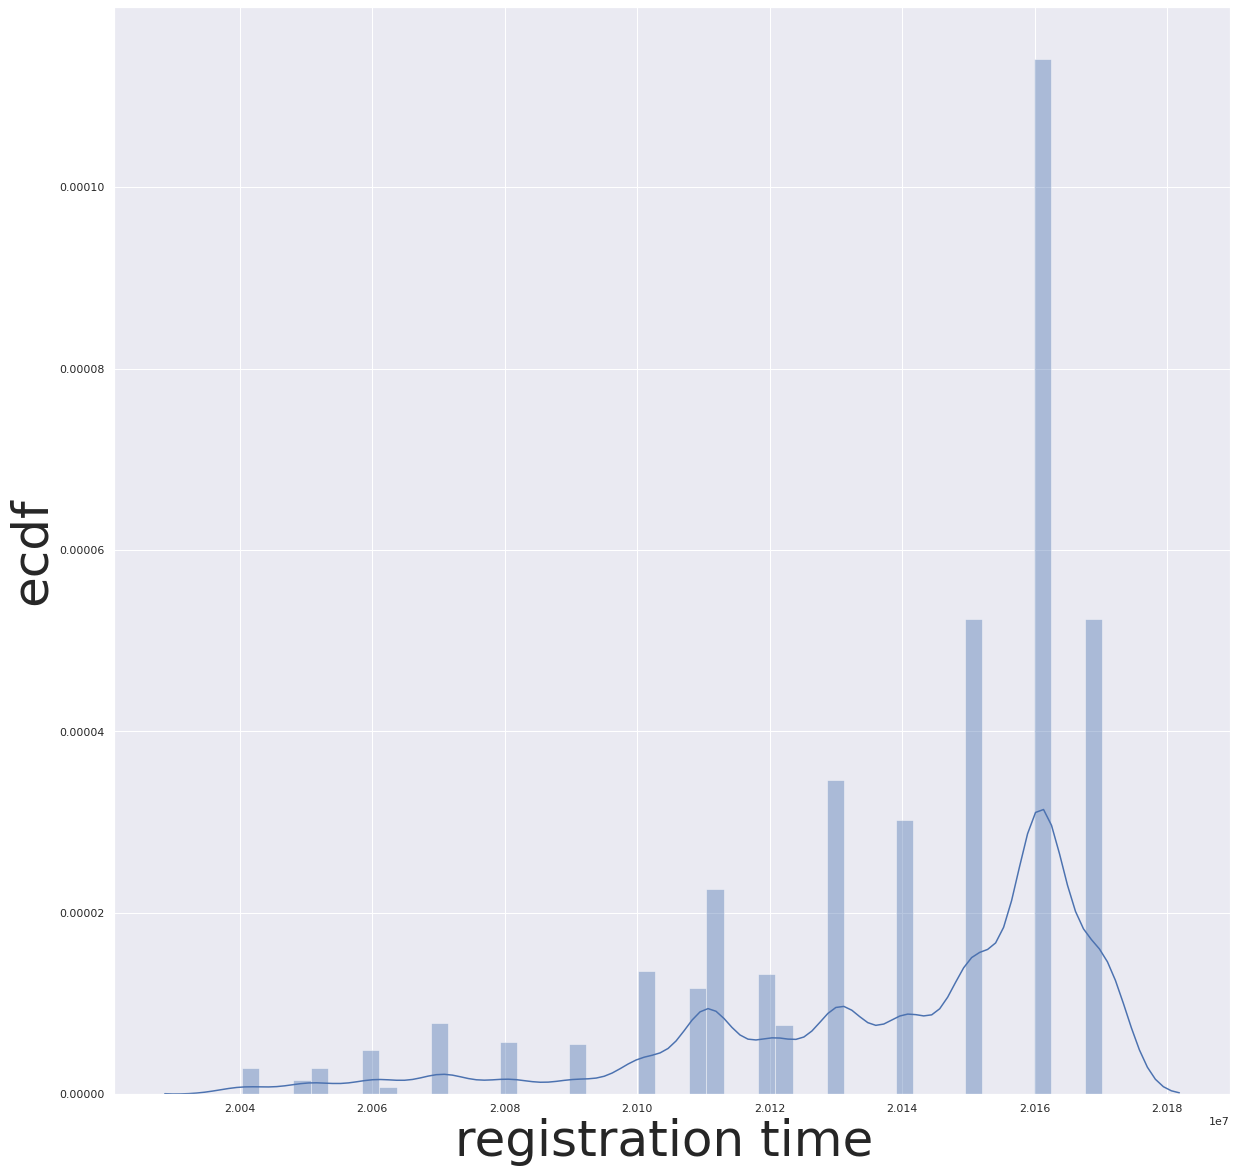

In [26]:
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
sns.distplot(members.registration_init_time)
sns.set(font_scale=2)
plt.ylabel('ecdf',fontsize=50)
plt.xlabel('registration time ' ,fontsize=50)

In [ ]:
train.describe()